# Calibration and Correction of State Preparation and Measurement (SPAM)

Quantum Computers available in the NISQ-era are limited by significant sources of device noise which cause errors in computation. One such noise source is errors in the preparation and measurement of quantum states, more commonly know as SPAM. <br>

If device SPAM error can be characterised, then device results can be modified to mitigate the error. Characterisation proceeds by determining overlap between different prepared basis states when measured, and mitigation modifies the distribution over output states of the corrected circuit. No modification of the quantum circuit being corrected is required. The ``` pytket```  ```SpamCorrecter```  class supports characterisation and mitigation of device SPAM error. <br>

In this tutorial we will show how the ```SpamCorrecter```  class can be used to modify real results and improve device performance when running experiments. <br>

This tutorial will require installation of ```pytket```, ```pytket_qiskit``` and ```qiskit```, all available on pip.

First, import the ```SpamCorrecter``` class. 

In [1]:
from pytket.utils.spam import SpamCorrecter

The SpamCorrecter class has methods for generating State Preparation and Measurement (SPAM) calibration experiments for pytket backends and correcting counts generated from those same backends. <br>

Let's first mitigate error from a noisy simulation, using a noise model straight from the 5-qubit IBMQ Ourense device. This will require a preloaded IBMQ account.

In [2]:
from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
from pytket.backends.ibm.ibm import process_device

In [4]:
ibmq_ourense_backend = IBMQ.providers()[0].get_backend('ibmq_ourense')
pytket_ourense_device = process_device(ibmq_ourense_backend)

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

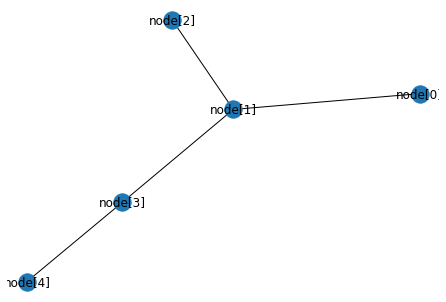

In [6]:
ourense_graph = nx.Graph(pytket_ourense_device.coupling)
nx.draw(ourense_graph, labels = {node:node for node in ourense_graph.nodes()})

SPAM correction requires subsets of qubits which are assumed to only have SPAM errors correlated with each other, and no other qubits. <br>
Correlated errors are usually dependent on the connectivity layout of devices, as shown above. <br>
As Ourense is a small 5-qubit device with few connections, let's assume that all qubits have correlated SPAM errors. The number of calibration circuits produced is exponential in the maximum number of correlated circuits, so finding good subsets of correlated qubits is important for characterising larger devices with smaller experimental overhead.

In [7]:
n_shots = 8192 
ourense_node_subsets = pytket_ourense_device.nodes
ourense_spam = SpamCorrecter([ourense_node_subsets])

The SpamCorrecter uses these subsets of qubits to produce calibration circuits.

In [8]:
calibration_circuits = ourense_spam.calibration_circuits()
print('Number of calibration circuits: ' , len(calibration_circuits))

Number of calibration circuits:  32


We get a noise model from ```ibmq_ourense``` using qiskit-aer, make a simulator backend, and then execute all calibration circuits through the backend.

In [9]:
from pytket.backends.ibm import AerBackend
from qiskit.providers.aer.noise import NoiseModel

In [10]:
pytket_noisy_sim_backend = AerBackend(NoiseModel.from_backend(ibmq_ourense_backend))
for c in calibration_circuits:
    pytket_noisy_sim_backend.compile_circuit(c)
sim_handles = pytket_noisy_sim_backend.process_circuits(calibration_circuits, n_shots)

Count results from the simulator are then used to calculate the matrices used for SPAM correction for ```ibmq_ourense```.

In [11]:
sim_count_results = (pytket_noisy_sim_backend.get_counts(handle) for handle in sim_handles)
ourense_spam.calculate_matrices(sim_count_results)

In [12]:
from pytket import Circuit

In [13]:
ghz_circuit = Circuit(len(pytket_ourense_device.nodes)).H(0).CX(0,1).CX(1,2).measure_all()
pytket_noisy_sim_backend.compile_circuit(ghz_circuit)
ghz_noisy_counts = pytket_noisy_sim_backend.get_counts(ghz_circuit,n_shots)

We also run a noiseless simulation so we can compare performance.

In [14]:
pytket_noiseless_sim_backend = AerBackend()
ghz_noiseless_counts = pytket_noiseless_sim_backend.get_counts(ghz_circuit,n_shots)

Noisy simulator counts are corrected using the ```SpamCorrecter``` objects ```correct_counts``` method.<br>
To correctly amend counts, the ```correct_counts``` method requires the executed circuits qubit_readout, a map from qubit to its index in readouts from backends.

In [15]:
ghz_spam_corrected_counts = ourense_spam.correct_counts(ghz_noisy_counts, ghz_circuit.qubit_readout)

Import and define the Jensen-Shannon divergence, which we will use for comparing performance. The Jensen-Shannon divergence is a symmetric and finite measure of similarity between two probability distributions. A smaller divergence implies more similarity between two probability distributions.

In [16]:
from scipy.stats import entropy
import numpy as np
import itertools

In [17]:
def binseq(k):
    return [''.join(x) for x in itertools.product('01', repeat=k)]

def probs_from_counts(counts):
    counts_dict = dict()
    for x in counts:
        counts_dict[''.join(str(e) for e in x)]=counts[x]
    converted = []
    binary_strings = binseq(len(list(counts.keys())[0]))
    for b in binary_strings:
        converted.append(counts_dict.get(b,0))
    return converted / np.sum(converted)

def JSD(P, Q):
    _P = P / np.linalg.norm(P, ord=1)
    _Q = Q / np.linalg.norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

Convert our counts results to a probability distribution over the basis states for comparison. 

In [18]:
ghz_noiseless_probabilities = probs_from_counts(ghz_noiseless_counts)
ghz_noisy_probabilities = probs_from_counts(ghz_noisy_counts)
ghz_spam_corrected_probabilities = probs_from_counts(ghz_spam_corrected_counts)

In [19]:
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and noisy simulation probability distribution: ',
      JSD(ghz_noiseless_probabilities, ghz_noisy_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and spam corrected noisy simulation probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_spam_corrected_probabilities))

Jensen-Shannon Divergence between noiseless simulation probability distribution and noisy simulation probability distribution:  0.049847889054048106
Jensen-Shannon Divergence between noiseless simulation probability distribution and spam corrected noisy simulation probability distribution:  0.009938424496939508


In our noisy simulated case, spam corrected results produced a distribution closer to the expected distribution. <br>
There are three methods available for correcting counts: the default ```minimise```, ```invert``` and ```bayesian```. Further information on each method is available at our [documentation](https://cqcl.github.io/pytket/build/html/utils.html#module-pytket.utils.spam).<br>
Let's look at how the ```bayesian``` method performs.

In [20]:
ghz_bayesian_corrected_counts = ourense_spam.correct_counts(ghz_noisy_counts, ghz_circuit.qubit_readout, method = 'bayesian')
ghz_bayesian_probabilities = probs_from_counts(ghz_bayesian_corrected_counts)

print('Jensen-Shannon Divergence between noiseless simulation probability distribution and minimise corrected noisy simulation probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_spam_corrected_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian corrected noisy simulation probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_bayesian_probabilities))

Jensen-Shannon Divergence between noiseless simulation probability distribution and minimise corrected noisy simulation probability distribution:  0.009938424496939508
Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian corrected noisy simulation probability distribution:  0.017218607227926827


Lets change from our simulator backend to the Ourense IBMQ device to see how SPAM correction performs on real results.

In [21]:
from pytket.backends.ibm import IBMQBackend
pytket_ourense_backend = IBMQBackend('ibmq_ourense')

In [22]:
all_circuits = calibration_circuits + [ghz_circuit]
for c in all_circuits:
    pytket_ourense_backend.compile_circuit(c) 
ourense_handles = pytket_ourense_backend.process_circuits(all_circuits, n_shots)

In [23]:
ourense_calibration_shot_results = (pytket_ourense_backend.get_counts(handle, n_shots) for handle in ourense_handles[:-1])
ourense_spam.calculate_matrices(ourense_calibration_shot_results)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

In [24]:
ghz_ourense_counts = pytket_ourense_backend.get_counts(ourense_handles[-1])
ghz_ourense_probabilities = probs_from_counts(ghz_ourense_counts)

Job Status: job has successfully run


Finally we compare performance for our machine results:

In [25]:
ghz_spam_corrected_ourense_counts = ourense_spam.correct_counts(ghz_ourense_counts, ghz_circuit.qubit_readout)
ghz_bayesian_corrected_counts = ourense_spam.correct_counts(ghz_ourense_counts, ghz_circuit.qubit_readout, method = 'bayesian')

ghz_spam_corrected_ourense_probabilities = probs_from_counts(ghz_spam_corrected_counts)
ghz_bayesian_probabilities = probs_from_counts(ghz_bayesian_corrected_counts)

print('Jensen-Shannon Divergence between noiseless simulation probability distribution and ourense probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_ourense_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and minimise corrected ourense probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_spam_corrected_ourense_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian corrected ourense probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_bayesian_probabilities))

Jensen-Shannon Divergence between noiseless simulation probability distribution and ourense probability distribution:  0.05170638162969758
Jensen-Shannon Divergence between noiseless simulation probability distribution and minimise corrected ourense probability distribution:  0.009938424496939508
Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian corrected ourense probability distribution:  0.008582662507406446
